In [1]:
# -*- coding: utf-8 -*-
import os
os.environ['CUDA_VISIBLE_DEVICES'] = ""
from keras.applications import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing import image
from keras.models import Model
from keras.applications.imagenet_utils import decode_predictions
import numpy as np
import cv2
from cv2 import *
import matplotlib.pyplot as plt
%matplotlib inline
import scipy as sp
from scipy.misc import toimage
import sys
sys.path.append("..")
from src.network.hiarGoogLenet import hiarGoogLeNet
from src.network.GoogleLenet import GoogLeNet
from src.network.hiarGoogLenet_high import hiarGoogLeNet_high
from src.network.hiarBayesGoogLenet import hiarBayesGoogLeNet

low_level = [27, 32, 50, 56]#, 61, 62, 63, 64
mid_level = [0, 6, 7, 8, 9, 11, 12, 13, 17, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30, 33, 35, 36, 37, 38, 39, 41, 42, 43, 44, 45, 46, 47, 48, 49, 51, 52, 53, 54, 55, 57, 58, 59, 60]
high_level = [1, 2, 3, 4, 5, 10, 14, 15, 16, 18, 19, 31, 34, 40]
image_width = 75
image_height = 160
model_h = hiarGoogLeNet.build(image_height, image_width, 3, [len(low_level), len(mid_level), len(high_level)])
model_h.load_weights("/home/anhaoran/codes/pedestrian_attibutes_wpal/models/imagenet_models/hiarGoogLeNet_PETA/binary61_final_model.h5")
model_g = GoogLeNet.build(image_height, image_width, 3, 61)
model_g.load_weights("../models/imagenet_models/GoogLeNet_PETA/binary61_final_model.h5")
#model_gh = hiarGoogLeNet_high.build(image_height, image_width, 3, [len(low_level), len(mid_level), len(high_level)])
#model_gh.load_weights("../models/imagenet_models/hiarGoogLeNet_PETA/binary61_high_final_model.h5")
model_hr = hiarBayesGoogLeNet.build(image_height, image_width, 3, [len(low_level), len(mid_level), len(high_level)])
model_hr.load_weights("../models/imagenet_models/hiarBayesGoogLeNet_PETA/binary61_multi_final500_model.h5")

Using TensorFlow backend.
../src/network/hiarBayesGoogLenet.py:77: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(isinstance(classes, list), 'Must be list type.')
../src/network/hiarBayesGoogLenet.py:78: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(len(classes) == 3, 'Must be 3 elements in the list.')


ImageNet...


In [3]:
def load_original(img_path, img_height, img_width):
    # 把原始图片压缩为 299*299大小
    img = image.load_img(img_path, target_size=(image_height, image_width, 3))
    plt.figure(0)
    plt.subplot(211)
    plt.imshow(img)
    return img

"""
def load_fine_tune_googlenet_v3(img):
    # 加载fine-tuning googlenet v3模型，并做预测
    model = InceptionV3(include_top=True, weights='imagenet')
    model.summary()
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    preds = model.predict(x)
    print('Predicted:', decode_predictions(preds))
    plt.subplot(212)
    plt.plot(preds.ravel())
    plt.show()
    return model, x
"""

"\ndef load_fine_tune_googlenet_v3(img):\n    # 加载fine-tuning googlenet v3模型，并做预测\n    model = InceptionV3(include_top=True, weights='imagenet')\n    model.summary()\n    x = image.img_to_array(img)\n    x = np.expand_dims(x, axis=0)\n    x = preprocess_input(x)\n    preds = model.predict(x)\n    print('Predicted:', decode_predictions(preds))\n    plt.subplot(212)\n    plt.plot(preds.ravel())\n    plt.show()\n    return model, x\n"

(1, 160, 75, 3)


"\nextract_features_batch(model_h, img_arr, 10, [1, 2, 3, 4, 5, 10, 15, 20, 25, 30, 40, 50, 70, 90, 110, 130], '../results/samples/sample_h.jpg')\nextract_features_batch(model_g, img_arr, 10, [1, 2, 3, 4, 5, 10, 15, 20, 25, 30, 40, 50, 70, 90, 110, 130], '../results/samples/sample_g.jpg')\nextract_features_batch(model_gh, img_arr, 10, [1, 2, 3, 4, 5, 10, 15, 20, 25, 30, 40, 50, 70, 90, 110, 130], '../results/samples/sample_gh.jpg')\n"

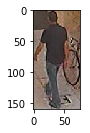

In [4]:
def extract_features(model, x, layer_id, filters, layer_num_list):
    '''
    提取指定模型指定层指定数目的feature map并输出到一幅图上.
    :param ins: 模型实例
    if len(ins) != 2:
        print('parameter error:(model, instance)')
        return None
    :param layer_id: 提取指定层特征
    :param filters: 每层提取的feature map数
    :param layer_num_list: 一共提取多少层feature map
    :return: None
    '''
    #model = ins[0]
    #x = ins[1]
    if type(layer_id) == type(1):
        model_extractfeatures = Model(inputs=model.input, outputs=model.get_layer(index=layer_id).output)
    else:
        model_extractfeatures = Model(inputs=model.input, outputs=model.get_layer(name=layer_id).output)
    #model_extractfeatures.summary()
    fc2_features = model_extractfeatures.predict(x)
    if filters > len(fc2_features[0][0][0]):
        print('layer number error.', len(fc2_features[0][0][0]),',',filters)
        return None
    for i in range(filters):
        #plt.subplots_adjust(left=0, right=1, bottom=0, top=1)
        plt.subplot(filters, len(layer_num_list), layer_num_list.index(layer_id) + 1 + i * len(layer_num_list) )
        plt.axis("off")
        if i < len(fc2_features[0][0][0]):
            plt.imshow(fc2_features[0, :, :, i])

# 层数、模型、卷积核数
def extract_features_batch(model, x, filters, layer_num_list, path):
    '''
    批量提取特征
    :param layer_num: 层数
    :param model: 模型
    :param filters: feature map数
    :return: None
    '''
    #plt.figure(figsize=(filters, layer_num))
    plt.subplot(filters, len(layer_num_list), 1)
    for i in layer_num_list:
        extract_features(model, x, i, filters, layer_num_list)
    plt.savefig(path, dpi=500, quality=95)
    plt.show()

def extract_features_with_layers(model, instance, layer_indexes, img_height=160, img_width=75):
    '''
    提取hypercolumn并可视化.
    :param layers_extract: 指定层列表
    :return: None
    '''
    hc = extract_hypercolumn(model, instance, layer_indexes, img_height, img_width)
    ave = np.average(hc.transpose(1, 2, 0), axis=2)
    plt.imshow(ave)
    plt.show()

def extract_hypercolumn(model, instance, layer_indexes, img_height=160, img_width=75):
    '''
    提取指定模型指定层的hypercolumn向量
    :param model: 模型
    :param layer_indexes: 层id
    :param instance: 输入
    :return:
    '''
    feature_maps = []
    for i in layer_indexes:
        feature_maps.append(Model(inputs=model.input, outputs=model.get_layer(index=i).output).predict(instance))
    hypercolumns = []
    for convmap in feature_maps:
        for i in range(len(convmap[0][0][0])):
            upscaled = sp.misc.imresize(convmap[0, :, :, i], size=(img_height, img_width), mode="F", interp='bilinear')
            hypercolumns.append(upscaled)
    return np.asarray(hypercolumns)


img_path = '/home/anhaoran/data/pedestrian_attributes_PETA/PETA/3DPeS/archive/191_494_FRAME_319_RGB.bmp'
img = load_original(img_path, image_height, image_width)
img_arr = image.img_to_array(img)
img_arr = np.expand_dims(img_arr, axis=0)
print(img_arr.shape)

"""
extract_features_batch(model_h, img_arr, 10, [1, 2, 3, 4, 5, 10, 15, 20, 25, 30, 40, 50, 70, 90, 110, 130], '../results/samples/sample_h.jpg')
extract_features_batch(model_g, img_arr, 10, [1, 2, 3, 4, 5, 10, 15, 20, 25, 30, 40, 50, 70, 90, 110, 130], '../results/samples/sample_g.jpg')
extract_features_batch(model_gh, img_arr, 10, [1, 2, 3, 4, 5, 10, 15, 20, 25, 30, 40, 50, 70, 90, 110, 130], '../results/samples/sample_gh.jpg')
"""
#extract_features_with_layers(model_h, img_arr, [1, 4, 7])
#extract_features_with_layers(model_h, img_arr, [1, 4, 7, 10, 11, 14, 17])

# Low&Mid level feature map

In [ ]:
model_h.summary()

In [ ]:
def extract_features_hiar_models(model, x, layer_id, filters, layer_num_list):
    '''
    提取指定模型指定层指定数目的feature map并输出到一幅图上.
    :param ins: 模型实例
    if len(ins) != 2:
        print('parameter error:(model, instance)')
        return None
    :param layer_id: 提取指定层特征
    :param filters: 每层提取的feature map数
    :param layer_num_list: 一共提取多少层feature map
    :return: None
    '''
    if type(layer_id) == type(1):
        model_extractfeatures = Model(inputs=model[i].input, outputs=model[i].get_layer(index=layer_id).output)
    else:
        model_extractfeatures = Model(inputs=model[i].input, outputs=model[i].get_layer(name=layer_id).output)
    #model_extractfeatures.summary()
    fc2_features = model_extractfeatures.predict(x)
    if filters > len(fc2_features[0][0][0]):
        print('layer number error.', len(fc2_features[0][0][0]),',',filters)
        return None
    for i in range(filters):
        #plt.subplots_adjust(left=0, right=1, bottom=0, top=1)
        plt.subplot(filters, len(layer_num_list), layer_num_list.index(layer_id) + 1 + i * len(layer_num_list) )
        plt.axis("off")
        if i < len(fc2_features[0][0][0]):
            plt.imshow(fc2_features[0, :, :, i])

# 层数、模型、卷积核数
def extract_features_batch_hiar_models(model, x, filters, layer_num_list, path):
    '''
    批量提取特征
    :param layer_num: 层数
    :param model: 模型
    :param filters: feature map数
    :return: None
    '''
    #plt.figure(figsize=(filters, layer_num))
    plt.subplot(filters, len(layer_num_list), 1)
    for i in layer_num_list:
        extract_features_hiar_models(model, x, i, filters, layer_num_list)
    plt.savefig(path, dpi=250, quality=95)
    plt.show()
    

for i in range(20):
    print("filter_", str(i))
    extract_features_batch_hiar_models(model_h, img_arr, i, [1, 2, 3, 4, 5, 10, 15, 20, 25, 30, 40, 50, 70, 90, 110, 130], '../results/samples/sample_all_model_filter'+str(i)+'.jpg')

# base feature map

/home/anhaoran/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


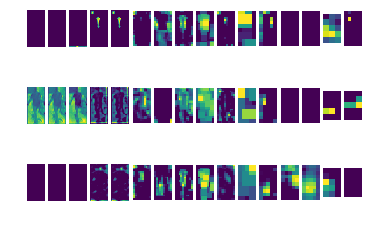

In [5]:
def extract_features_allmodels(model, x, layer_id, filter_id, layer_num_list):
    '''
    提取指定模型指定层指定数目的feature map并输出到一幅图上.
    :param ins: 模型实例
    if len(ins) != 2:
        print('parameter error:(model, instance)')
        return None
    :param layer_id: 提取指定层特征
    :param filters: 每层提取的feature map数
    :param layer_num_list: 一共提取多少层feature map
    :return: None
    '''
    for i in range(len(model)):
        if type(layer_id) == type(1):
            model_extractfeatures = Model(inputs=model[i].input, outputs=model[i].get_layer(index=layer_id).output)
        else:
            model_extractfeatures = Model(inputs=model[i].input, outputs=model[i].get_layer(name=layer_id).output)
        #model_extractfeatures.summary()
        fc2_features = model_extractfeatures.predict(x)
        if filter_id > len(fc2_features[0][0][0]):
            print('layer number error.', len(fc2_features[0][0][0]),',',filter_id)
            return None
        #plt.subplots_adjust(left=0, right=1, bottom=0, top=1)
        plt.subplot(len(model), len(layer_num_list), layer_num_list.index(layer_id) + 1 + i * len(layer_num_list) )
        plt.axis("off")
        if filter_id < len(fc2_features[0][0][0]):
            plt.imshow(fc2_features[0, :, :, filter_id])
            plt.savefig("../results/1.jpg", dpi=250, quality=95)

# 层数、模型、卷积核数
def extract_features_batch_allmodels(model, x, filter_id, layer_num_list, path):
    '''
    批量提取特征
    :param layer_num: 层数
    :param model: 模型
    :param filters: feature map数
    :return: None
    '''
    #plt.figure(figsize=(filters, layer_num))
    plt.subplot(len(model), len(layer_num_list), 1)
    for i in layer_num_list:
        extract_features_allmodels(model, x, i, filter_id, layer_num_list)
    plt.savefig(path, dpi=250, quality=95)
    plt.show()
    

#for i in range(20):
#    print("filter_", str(i))
extract_features_batch_allmodels([model_hr, model_h, model_g], img_arr, 0, [1, 2, 3, 4, 5, 10, 15, 20, 25, 30, 40, 50, 70, 90, 110, 130], '../results/samples/sample_all_model_filter'+str(0)+'.jpg')

/home/anhaoran/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


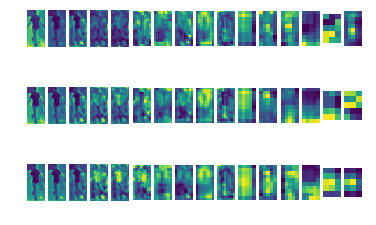

In [9]:
def extract_sumfeatures_allmodels(model, x, layer_id, layer_num_list):
    '''
    提取指定模型指定层指定数目的feature map并输出到一幅图上.
    :param ins: 模型实例
    if len(ins) != 2:
        print('parameter error:(model, instance)')
        return None
    :param layer_id: 提取指定层特征
    :param filters: 每层提取的feature map数
    :param layer_num_list: 一共提取多少层feature map
    :return: None
    '''
    for i in range(len(model)):
        if type(layer_id) == type(1):
            model_extractfeatures = Model(inputs=model[i].input, outputs=model[i].get_layer(index=layer_id).output)
        else:
            model_extractfeatures = Model(inputs=model[i].input, outputs=model[i].get_layer(name=layer_id).output)
        #model_extractfeatures.summary()
        fc2_features = model_extractfeatures.predict(x)
        #plt.subplots_adjust(left=0, right=1, bottom=0, top=1)
        plt.subplot(len(model), len(layer_num_list), layer_num_list.index(layer_id) + 1 + i * len(layer_num_list) )
        plt.axis("off")
        plt.imshow(np.sum(fc2_features[0, :, :, :], axis=2))
        plt.savefig("../results/1.jpg", dpi=250, quality=95)

# 层数、模型、卷积核数
def extract_sumfeatures_batch_allmodels(model, x, layer_num_list, path):
    '''
    批量提取特征
    :param layer_num: 层数
    :param model: 模型
    :param filters: feature map数
    :return: None
    '''
    #plt.figure(figsize=(filters, layer_num))
    plt.subplot(len(model), len(layer_num_list), 1)
    for i in layer_num_list:
        extract_sumfeatures_allmodels(model, x, i, layer_num_list)
    plt.savefig(path, dpi=250, quality=95)
    plt.show()
    

#for i in range(20):
#    print("filter_", str(i))
extract_sumfeatures_batch_allmodels([model_hr, model_h, model_g], img_arr, [1, 2, 3, 4, 5, 10, 15, 20, 25, 30, 40, 50, 70, 90, 110, 130], '../results/samples/sample_all_model_filter'+str(0)+'.jpg')

In [ ]:
Model(inputs=model.input, outputs=model.get_layer(index=layer_id).output)

# Weights

In [10]:
from src.network.hiarBayesGoogLenet import hiarBayesGoogLeNet

In [11]:
model_hr = hiarBayesGoogLeNet.build(image_height, image_width, 3, [len(low_level), len(mid_level), len(high_level)])
model_hr.load_weights("/home/anhaoran/codes/pedestrian_attibutes_wpal/models/imagenet_models/hiarBayesGoogLeNet_PETA/binary61_multi_final_model.h5")

In [12]:
model_hr.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 160, 75, 3)   0                                            
__________________________________________________________________________________________________
conv1_7x7_s2 (Conv2D)           (None, 80, 38, 64)   9472        input_4[0][0]                    
__________________________________________________________________________________________________
conv1_7x7_s2_bn (BatchNormaliza (None, 80, 38, 64)   256         conv1_7x7_s2[0][0]               
__________________________________________________________________________________________________
max_pooling2d_40 (MaxPooling2D) (None, 40, 19, 64)   0           conv1_7x7_s2_bn[0][0]            
__________________________________________________________________________________________________
conv2_3x3 

In [13]:
weights = model_hr.get_layer('high_cond').get_weights()
print(weights)

[array([[-8.88814926e-01,  9.26568091e-01, -3.99266750e-01,
        -1.18520534e+00, -7.84428954e-01, -9.59272921e-01,
        -4.04158175e-01,  4.37925495e-02, -1.78039014e+00,
        -1.08930683e+00, -1.34683883e+00, -7.58984387e-01,
        -6.96536377e-02, -8.45460117e-01],
       [-6.29673526e-02,  1.23107873e-01,  8.46137777e-02,
        -4.45429564e-01, -1.38495322e-02, -4.11410451e-01,
         1.96292683e-01,  5.60126118e-02, -8.49808395e-01,
        -1.72819763e-01,  9.00157765e-02, -2.39601597e-01,
         4.01569909e-04, -2.07700357e-01],
       [ 1.30305135e+00,  9.64093089e-01, -4.93524551e-01,
        -7.32405365e-01, -7.69868433e-01,  5.47400773e-01,
         1.08024693e+00,  2.44109586e-01, -3.47159833e-01,
        -4.60683763e-01, -5.53538382e-01, -6.28140926e-01,
        -5.46820760e-01, -7.38448024e-01],
       [ 3.21376830e-01,  6.36975288e-01,  4.29113805e-02,
        -2.55443633e-01, -1.06662178e+00,  1.04670072e+00,
         6.11878395e-01,  3.08323771e-01, -2

In [14]:
print(weights[0].shape)

(47, 14)


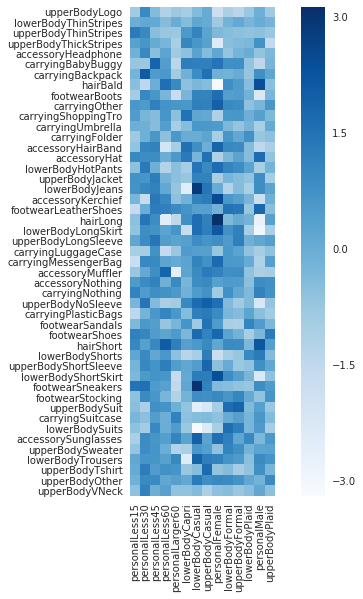

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plt.subplots(figsize=(9, 9))
sns.heatmap(weights[0], cmap="Blues", square=True, 
            xticklabels = ['personalLess15', 'personalLess30', 'personalLess45', 'personalLess60', 'personalLarger60', 'lowerBodyCapri', 'lowerBodyCasual', 'upperBodyCasual', 'personalFemale', 'lowerBodyFormal', 'upperBodyFormal', 'lowerBodyPlaid', 'personalMale', 'upperBodyPlaid'], 
            yticklabels = ['upperBodyLogo', 'lowerBodyThinStripes', 'upperBodyThinStripes', 'upperBodyThickStripes', 'accessoryHeadphone', 'carryingBabyBuggy', 'carryingBackpack', 'hairBald', 'footwearBoots', 'carryingOther', 'carryingShoppingTro', 'carryingUmbrella', 'carryingFolder', 'accessoryHairBand', 'accessoryHat', 'lowerBodyHotPants', 'upperBodyJacket', 'lowerBodyJeans', 'accessoryKerchief', 'footwearLeatherShoes', 'hairLong', 'lowerBodyLongSkirt', 'upperBodyLongSleeve', 'carryingLuggageCase', 'carryingMessengerBag', 'accessoryMuffler', 'accessoryNothing', 'carryingNothing', 'upperBodyNoSleeve', 'carryingPlasticBags', 'footwearSandals', 'footwearShoes', 'hairShort', 'lowerBodyShorts', 'upperBodyShortSleeve', 'lowerBodyShortSkirt', 'footwearSneakers', 'footwearStocking', 'upperBodySuit', 'carryingSuitcase', 'lowerBodySuits', 'accessorySunglasses', 'upperBodySweater', 'lowerBodyTrousers', 'upperBodyTshirt', 'upperBodyOther', 'upperBodyVNeck'])
plt.show()